## **Regression Models**

---



Using the insights from our data analysis:
- we've decided to choose MAE metric for our models based on the fact that our data is skewed.
- We've also tested outlier removal
- We split the dataset into a train and test split using stratification(80%,20%).
- We did cross-validation on the training set to have an idea on the best models.
- We made predictions on the test set.
- We also did a custom neural network and evaluated our training set on it.
- Our best model is Random Forest


#Imports

In [1]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm
import time
import numpy as np
import scipy as sp
import keras
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.linear_model import LinearRegression, Ridge,ElasticNet,Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import xgboost as xgb
import lightgbm as lgb
from sklearn.feature_selection import variance_threshold, univariate_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler,PowerTransformer,OneHotEncoder
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    classification_report,
    f1_score,
    roc_curve,
    fbeta_score,
    make_scorer
)

from scipy.stats import norm, skew, zscore
from scipy.special import boxcox1p

from sklearn.decomposition import PCA, NMF
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

#Functions

In [2]:
def load_format_dataset(path='challenge_youtube_toxic.csv'):
    df = pd.read_csv(path,encoding='iso-8859-1',  delimiter=";",error_bad_lines=False )
    df = df.drop(['Unnamed: 27'],1)
    for i in df.columns:
        if (i.startswith('nbr') & (df[i].dtype=='O')):
            df[i] = df[i].apply(lambda x: float(x.replace(',','.')))

    #Check some logical properties: NbreMot>nbrMot_
    l = [col for col in df.columns if (col.startswith('nbrMot') and (df.nbrMot > df[col]).any())  ]
    #print(l)

    #Drop rows
    for col in l:
        df = df[df.nbrMot > df[col] ]

    df.reset_index(inplace=True,drop=True )
    return df.drop(['video_id_court', 'video_id','channel_id'],1)

def feature_engineering(df, target='target'):
    
    #weighted average of Number of insults *per channel* for train set 
    insults_per_channel = df['channel_name'].map(df.groupby('channel_name')[target].sum())
    samples_per_channel = df['channel_name'].map(df.groupby('channel_name')[target].count())
    df['reputation_channel'] = insults_per_channel/samples_per_channel
    df['viewer_interaction_video'] = df['message_count']/df['viewCount']
    df['viewCount_channel'] = df['channel_name'].map(df.groupby('channel_name')['viewCount'].sum())
    df['message_count_channel'] = df['channel_name'].map(df.groupby('channel_name')['message_count'].sum())
    df['viewer_interaction_channel'] = df['message_count_channel']/df['viewCount_channel']
    df['viewCount_channel_vs_subscribers'] = df['subscriberCount']/df['viewCount_channel']
    #Supposing number of subscribers always goes up over time
    #Let's study the effect of viewer behaviour over target
    df['insult_increase_time_coef_channel'] = df['channel_name'].map(df.groupby('channel_name')['subscriberCount'].sum())

    df['nbrQuestMark_channel'] = df['channel_name'].map(df.groupby('channel_name')['nbrQuestMark'].sum())
    df['nbrExclMark_channel'] = df['channel_name'].map(df.groupby('channel_name')['nbrExclMark'].sum())
    df['nbrMotAllong_channel'] = df['channel_name'].map(df.groupby('channel_name')['nbrMotAllong'].sum())

                                   
    df['MAJ_>_quantile_channel'] = df['nbrQuestMark_channel'] > df['nbrQuestMark_channel'].quantile(.75)
    df['!_>_quantile_channel'] = df['nbrExclMark_channel'] > df['nbrExclMark_channel'].quantile(.75)
    df['allong_>_quantile_channel'] = df['nbrMotAllong_channel'] > df['nbrMotAllong_channel'].quantile(.75)
    
    df['MAJ_<_quantile_channel'] = df['nbrQuestMark'] < df['nbrQuestMark'].quantile(.25)
    df['!_<_quantile_channel'] = df['nbrExclMark_channel'] < df['nbrExclMark_channel'].quantile(.25)
    df['allong_<_quantile_channel'] = df['nbrMotAllong_channel'] < df['nbrMotAllong_channel'].quantile(.25)
    
    return df

def crossvalidation_mixed_data(df):
    pipelines = []
    pipelines.append(("ScaledLR",Pipeline([("Scaler", StandardScaler()), ("LR", LinearRegression())])))
    pipelines.append(("ScaledRG",Pipeline([("Scaler", StandardScaler()), ("RG", Ridge())])))
    pipelines.append(("ScaledKNN",Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsRegressor())])))
    pipelines.append(("ScaledLasso",Pipeline([("Scaler", StandardScaler()), ("LS", Lasso())])))
    pipelines.append(("ScaledEN",Pipeline([("Scaler", StandardScaler()), ("EN",ElasticNet())])))
    pipelines.append(("ScaledSVR",Pipeline([("Scaler", StandardScaler()), ("SVR", SVR(kernel="linear"))])))
    pipelines.append(("GBM", GradientBoostingRegressor()))
    pipelines.append(("XGB", XGBRegressor()))
    pipelines.append(("RF", RandomForestRegressor()))
    pipelines.append(("LGBM", LGBMRegressor()))
    results = []
    names = []

    for name, model in tqdm(pipelines):
        cv_results = []
        kfold = KFold(n_splits=5, random_state=21)
        for train_index, test_index in kfold.split(df):
            model.fit(df.iloc[train_index, :-1], df.iloc[train_index, -1])
            cv_results.append(
                mean_absolute_error(
                    df.iloc[test_index, -1],
                    model.predict(df.iloc[test_index, :-1]),
                )
            )

        results.append(cv_results)
        names.append(name)
    plt.figure()
    plt.boxplot(results, labels=names)
    plt.xticks(rotation=25)
    plt.title('mean absolute error for baseline model')
    plt.show()
    return names, results

#No regularisation ==> Leakage
def mean_encoding(df_train, df_test, target='nomMotInsulte'):
    for name_categorical_column in df_train.dtypes[df_train.dtypes=='object'].index.tolist():
        means = df_train.groupby(name_categorical_column).target.mean()
        Mean_encoded_dict = means.to_dict()
        df_train[name_categorical_column] =  df_train[name_categorical_column].map(Mean_encoded_dict)
        df_test[name_categorical_column] =  df_test[name_categorical_column].map(Mean_encoded_dict)
        #in case test set contains categories not found in train set
        df_test[name_categorical_column].fillna(means.mean(), inplace = True)

    return df_train, df_test

#From Kaggle
def encode_target_smooth(data, target, categ_variables, smooth):
    """
    Apply target encoding with smoothing.

    Parameters
    ----------
    data: pd.DataFrame
    target: str, dependent variable
    categ_variables: list of str, variables to encode
    smooth: int, number of observations to weigh global average with

    Returns
    --------
    encoded_dataset: pd.DataFrame
    code_map: dict, mapping to be used on validation/test datasets
    defaul_map: dict, mapping to replace previously unseen values with
    """
    train_target = data.copy()
    code_map = dict()    # stores mapping between original and encoded values
    default_map = dict() # stores global average of each variable

    for v in categ_variables:
        prior = data[target].mean()
        n = data.groupby(v).size()
        mu = data.groupby(v)[target].mean()
        mu_smoothed = (n * mu + smooth * prior) / (n + smooth)

        train_target.loc[:, v] = train_target[v].map(mu_smoothed)
        code_map[v] = mu_smoothed
        default_map[v] = prior
    return train_target, code_map, default_map

def scale(df):
    from sklearn.preprocessing import MinMaxScaler
    scaler = MinMaxScaler()
    columns = df.columns
    df= scaler.fit_transform(df)
    df = pd.DataFrame(df, columns = columns)
    return df


def remove_outliers(df):

    df = scale(df)
    print(df.describe())
    outlier_detection = DBSCAN(
    eps = .75,
    metric="euclidean",
    min_samples = 5,
    n_jobs = -1)
    print(list(df.columns))
    df1=df.copy()
    target = df1.pop('target')

    clusters = outlier_detection.fit(df1)
    # Abstracting the data points
    labels = clusters.labels_
    print(" labels.shape ",labels.shape)


    # counting the number of outliers
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    n_noise_ = list(labels).count(-1)

    return labels
    
def remove_outliers_zscore(df,thresh = 5):
    #univariate outlier
    scaled = scale(df)
    df.reset_index(drop=True,inplace=True)
    scaled.reset_index(drop=True,inplace=True)
    z = np.abs(zscore(scaled))

    index_rows, index_cols = np.where(z > thresh)
    #scaled_outliers = scaled.iloc[index_rows, index_cols]
    #print(scaled_outliers.shape)
    df.drop(index_rows,axis=0,inplace=True)
    return df

# pearson's correlation feature selection
def feature_selection(removed_outliers,X_test, k='all'):

    # pearson's correlation feature selection for numeric input and numeric output

    from sklearn.feature_selection import SelectKBest
    from sklearn.feature_selection import f_regression
    # generate dataset
    ro_df = removed_outliers.copy()
    y, X = ro_df.pop('target'), ro_df
    # define feature selection
    fs = SelectKBest(score_func=f_regression, k=k)
    fs.fit(X, y)
    # apply feature selection
    #X_train_fs = fs.transform(X)
    # transform test input data
    #X_test_fs = fs.transform(X_test)
    cols = fs.get_support(indices=True)
    X_train_fs = X.iloc[:,cols]
    X_test_fs = X_test.iloc[:,cols]
    return X_train_fs, X_test_fs, fs

 # feature selection
def select_features(removed_outliers, df_test,score_func,k='all' ):

    X_train, y_train = removed_outliers.iloc[:,1:],removed_outliers.iloc[:,0]
    X_test = df_test.iloc[:,1:]
    # configure to select all features
    fs = SelectKBest(score_func=score_func, k=k)
    # learn relationship from training data
    fs.fit(X_train, y_train)
    cols = fs.get_support(indices=True)
    X_train_fs = X_train.iloc[:,cols]
    X_test_fs = X_test.iloc[:,cols]
    plt.figure()
    plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
    plt.show()
    
    return X_train_fs, X_test_fs, fs


def smooth_train_test(train_dataset, test_dataset,categorical_columns):
    train_target_smooth, target_map, default_map = encode_target_smooth(train_dataset, 'target', categorical_columns, 500)
    test_target_smooth = test_dataset.copy()
    for v in categorical_columns:
        test_target_smooth.loc[:, v] = test_target_smooth[v].map(target_map[v])

    return train_target_smooth, test_target_smooth

def predict(df_train,df_test):
    pipelines = []
    pipelines.append(("ScaledLR",Pipeline([("Scaler", StandardScaler()), ("LR", LinearRegression())])))
    pipelines.append(("ScaledRG",Pipeline([("Scaler", StandardScaler()), ("RG", Ridge())])))
    pipelines.append(("ScaledKNN",Pipeline([("Scaler", StandardScaler()), ("KNN", KNeighborsRegressor())])))
    pipelines.append(("ScaledLasso",Pipeline([("Scaler", StandardScaler()), ("LS", Lasso())])))
    pipelines.append(("ScaledEN",Pipeline([("Scaler", StandardScaler()), ("EN",ElasticNet())])))
    pipelines.append(("ScaledSVR",Pipeline([("Scaler", StandardScaler()), ("SVR", SVR(kernel="linear"))])))
    pipelines.append(("GBM", GradientBoostingRegressor()))
    pipelines.append(("XGB", XGBRegressor()))
    pipelines.append(("RF", RandomForestRegressor()))
    pipelines.append(("LGBM", LGBMRegressor()))
    results = []
    names = []

    for name, model in tqdm(pipelines):

            model.fit(df_train.iloc[:, :-1], df_train.iloc[:, -1])
            results.append([
                mean_absolute_error(
                    df_test.iloc[:, -1],
                    model.predict(df_test.iloc[:, :-1]),
                )]
            )


            names.append(name)
    plt.figure()
    plt.boxplot(results, labels=names)
    plt.xticks(rotation=25)
    plt.title('mean absolute error for baseline model')
    return names, results
def train(X_train_fs, removed_outliers):
    df_to_train_model = X_train_fs.copy()
    df_to_train_model["target"] = removed_outliers.target
    names, results = crossvalidation_mixed_data(df_to_train_model)
    return df_to_train_model, names, results
def train_test_split_stratified(X,y):
    bins = np.linspace(0, X.shape[0], 10)
    # Save your Y values in a new ndarray,
    # broken down by the bins created above.
    y_binned = np.digitize(y, bins)
    # Pass y_binned to the stratify argument,
    # and sklearn will handle the rest
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=48, stratify=y_binned)
    return X_train,X_test,y_train, y_test

def baseline_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=18, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

def larger_model():
    # create model
    model = Sequential()
    model.add(Dense(13, input_dim=18, kernel_initializer='normal', activation='relu'))
    model.add(Dense(6, kernel_initializer='normal', activation='relu'))
    model.add(Dense(3, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_absolute_error', optimizer='adam')
    return model

#I/Without Feature engineering

### A/With Outlier removal

Note that the dataset contains categorical and numerical variables.
We will need to take this into account when preprocessing the dataset
thereafter.

In [3]:
df = load_format_dataset()
print(df.describe())
target = df.pop('nbrMotInsulte')
df['nbrMotInsulte'] = target
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
print(X.head())


              nbrMot  nbrMotInsulte  ...  subscriberCount     viewCount
count   32602.000000   32602.000000  ...     32602.000000  3.260200e+04
mean     2021.061959      13.247776  ...    188995.037973  1.006820e+08
std      9057.404702      72.928339  ...    122590.915883  6.841188e+07
min         2.000000       0.000000  ...         0.000000  3.109100e+04
25%        51.000000       0.000000  ...    148033.000000  4.667016e+07
50%       172.000000       1.000000  ...    189971.000000  8.553618e+07
75%       833.000000       6.000000  ...    217835.000000  1.345704e+08
max    662808.000000    7227.000000  ...    568615.000000  2.414350e+08

[8 rows x 21 columns]
   nbrMot  nbrMotAllong  nbrMotMAJ  ...  viewCount  categorie_new        categ_inst
0    3813             4        145  ...  225393312           Core      Pure Players
1      28             0          1  ...  132125693           Core                TV
2    3804             9         56  ...  225393312           Core      Pure P


Our target for prediction: 'nbrMotInsulte'.
'nbrMotInsulte' is described as an int.



In [4]:
print(y.head())

0    18
1     2
2    68
3     0
4     3
Name: nbrMotInsulte, dtype: int64


We split the sample into a train and a test dataset using stratification.


In [5]:
X_train, X_test, y_train, y_test = train_test_split_stratified(X,y)

We rename the target column by "target".
We insert it in the first column

In [6]:
train_dataset = X_train.copy()
train_dataset.insert(0, "target", y_train)
test_dataset = X_test.copy()
test_dataset.insert(0, "target", y_test)

To design our machine-learning pipeline, we first manually
check the type of data that we are dealing with:



In [7]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26081 entries, 27936 to 5211
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   target                   26081 non-null  int64  
 1   nbrMot                   26081 non-null  int64  
 2   nbrMotAllong             26081 non-null  int64  
 3   nbrMotMAJ                26081 non-null  int64  
 4   nbrExclMark              26081 non-null  int64  
 5   nbrQuestMark             26081 non-null  int64  
 6   nbrMotMoyenne            26081 non-null  float64
 7   nbrMotInsulteMoyenne     26081 non-null  float64
 8   nbrMotAllongMoyenne      26081 non-null  float64
 9   nbrMotMAJMoyenne         26081 non-null  float64
 10  nbrExclMarkMoyenne       26081 non-null  float64
 11  nbrQuestMarkMoyenne      26081 non-null  float64
 12  thread_count             26081 non-null  int64  
 13  comment_count            26081 non-null  int64  
 14  message_count      

Categorical variables cannot be included in linear model if not
coded as integers first. In addition, to avoid categorical features to be
treated as ordered values, we need to mean-encode them using regularization.


In [8]:
categorical_columns = [col  for col in train_dataset.columns if (train_dataset[col].dtype=='O')]
numerical_columns = [col  for col in train_dataset.columns if (train_dataset[col].dtype!='O')]
#Mean Encoding with regularization
train_target_smooth,test_target_smooth=smooth_train_test(train_dataset, test_dataset,categorical_columns)

Remove outliers using z_score

In [9]:
removed_outliers = remove_outliers_zscore(train_target_smooth)

Correlation feature selection:

1/ Using Pearson correlation



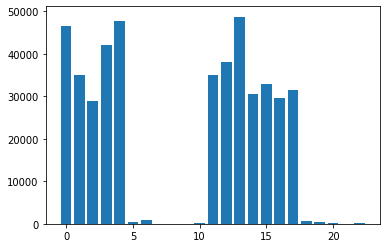

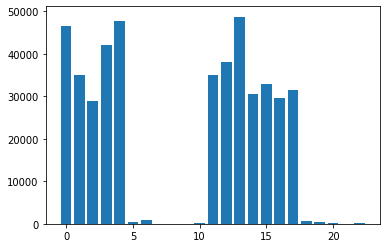

In [10]:
X_train_fs, X_test_fs, fs = select_features(removed_outliers, test_target_smooth,f_regression, k='all')
#12 features are clearly more important than others the highest of them being comment_count
X_train_fs_c, X_test_fs_c, fs_c = select_features(removed_outliers, test_target_smooth,f_regression, k=15)


2/ Using Mutual information

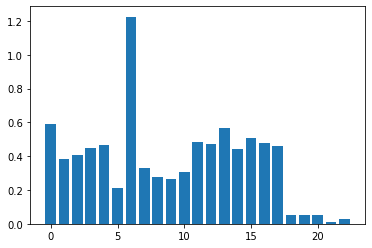

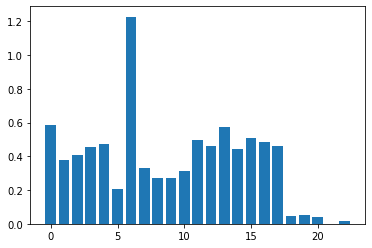

In [11]:
#Mutual Information Feature Selection
X_train_fs, X_test_fs, fs = select_features(removed_outliers, test_target_smooth,mutual_info_regression, k='all')
#18 features are clearly more important than others
X_train_fs_m, X_test_fs_m, fs_m = select_features(removed_outliers, test_target_smooth,mutual_info_regression, k=18)

##Model using mutual information selection
   


 70%|███████   | 7/10 [03:55<02:33, 51.22s/it]

[16:39:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:15] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:16] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:39:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [04:54<00:00, 29.48s/it]


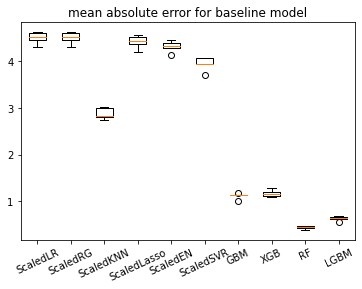

In [12]:
df_to_train_model_1,names_1, results_1 = train(X_train_fs_m, removed_outliers)

##Predict

 70%|███████   | 7/10 [01:09<00:45, 15.02s/it]

[16:41:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [01:24<00:00,  8.42s/it]


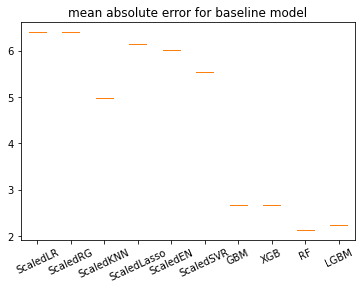

In [13]:
df_to_test_model_1 = X_test_fs_m.copy()
df_to_test_model_1["target"] = y_test
n,r = predict(df_to_train_model_1, df_to_test_model_1)
time.sleep(5)

##Model using pearson correlation selection

 70%|███████   | 7/10 [02:49<01:50, 36.97s/it]

[16:44:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:33] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:44:34] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [03:36<00:00, 21.67s/it]


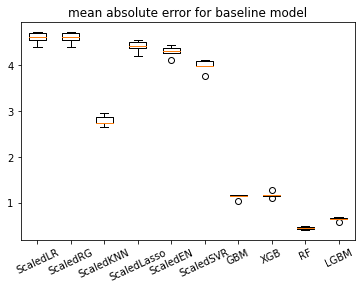

In [14]:
df_to_train_model_2,names_2, results_2 = train(X_train_fs_c, removed_outliers)


##Predict

 70%|███████   | 7/10 [00:48<00:31, 10.63s/it]

[16:46:12] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [01:00<00:00,  6.08s/it]


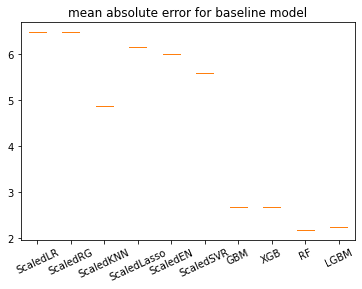

In [15]:
df_to_test_model_2 = X_test_fs_c.copy()
df_to_test_model_2["target"] = y_test
n,r = predict(df_to_train_model_2, df_to_test_model_2)


### B/Without Outlier removal

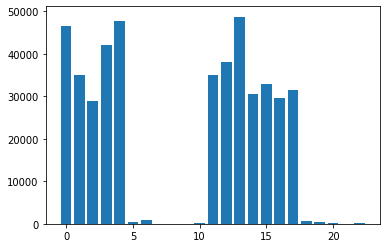

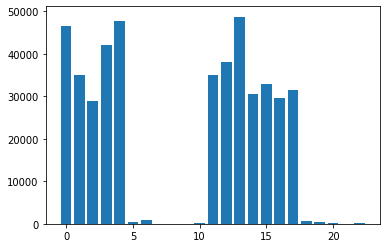

In [47]:
X_train_fs, X_test_fs, fs = select_features(train_target_smooth, test_target_smooth,f_regression, k='all')
#12 features are clearly more important than others the highest of them being comment_count
X_train_fs_c_wor, X_test_fs_c_wor, fs_c_wor = select_features(train_target_smooth, test_target_smooth,f_regression, k=18)

 70%|███████   | 7/10 [03:33<02:19, 46.53s/it]

[18:01:04] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:07] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:01:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [04:27<00:00, 26.77s/it]


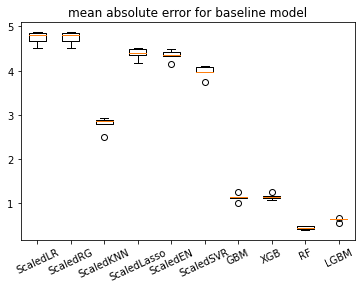

In [48]:
df_to_train_model_5,names_5, results_5 = train(X_train_fs_c_wor, train_target_smooth)

 70%|███████   | 7/10 [01:07<00:24,  8.18s/it]

[18:03:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [01:20<00:00,  8.07s/it]


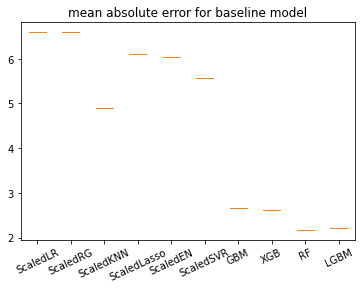

In [49]:
df_to_test_model_5 = X_test_fs_c_wor.copy()
df_to_test_model_5["target"] = y_test_fe
n,r = predict(df_to_train_model_5, df_to_test_model_5)

#II/With Feature engineering

Prepping dataset

In [16]:
df_o = load_format_dataset()
df_fe = feature_engineering(df_o,target='nbrMotInsulte')
target = df_fe.pop('nbrMotInsulte')
df_fe['nbrMotInsulte'] = target
X_fe = df_fe.iloc[:,:-1]
y_fe = df_fe.iloc[:,-1]
X_train_fe, X_test_fe, y_train_fe, y_test_fe =train_test_split_stratified( X_fe, y_fe)
train_dataset_fe = X_train_fe.copy()
train_dataset_fe.insert(0, "target", y_train_fe)
test_dataset_fe = X_test_fe.copy()
test_dataset_fe.insert(0, "target", y_test_fe)

- Mean encoding

- Outliers' removal

- Feature selection(pearson correlation)

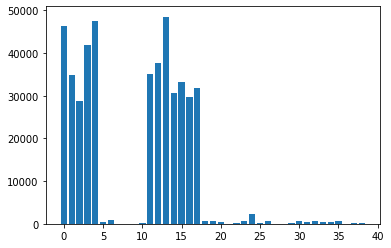

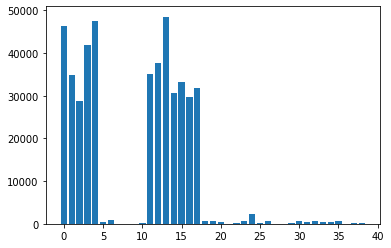

In [17]:
#Using smoothing encoding
train_target_smooth_fe,test_target_smooth_fe = smooth_train_test(train_dataset_fe, test_dataset_fe,categorical_columns)
removed_outliers_fe = remove_outliers_zscore(train_target_smooth_fe)
#Correlation feature selection
X_train_fs, X_test_fs, fs = select_features(removed_outliers_fe, test_target_smooth_fe,f_regression, k='all')
#15 features are clearly more important than others the highest of them being comment_count
X_train_fs_c_fe, X_test_fs_c_fe, fs_fe = select_features(removed_outliers_fe, test_target_smooth_fe,f_regression, k=19)

Mutual information feature selection

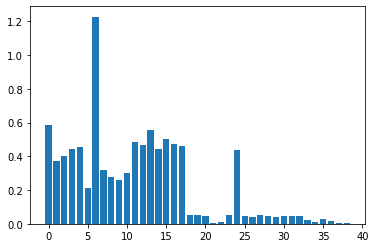

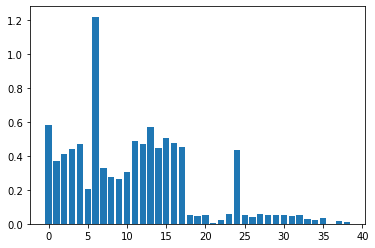

In [37]:
#Mutual Information Feature Selection
X_train_fs, X_test_fs, fs = select_features(removed_outliers_fe, test_target_smooth_fe,mutual_info_regression, k='all')
#21 features are clearly more important than others
X_train_fs_m_fe, X_test_fs_m_fe, fs_m_fe = select_features(removed_outliers_fe, test_target_smooth_fe,mutual_info_regression, k=32)


Model with feature engineering Pearson Correlation feature selection

 70%|███████   | 7/10 [03:07<02:02, 40.89s/it]

[16:50:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:50:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:50:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:50:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:50:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [04:00<00:00, 24.09s/it]


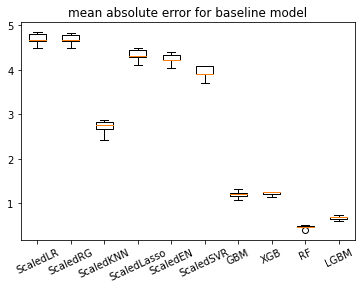

In [19]:
df_to_train_model_3,names_3, results_3 = train(X_train_fs_c_fe, removed_outliers_fe)


Predict

 70%|███████   | 7/10 [00:57<00:37, 12.55s/it]

[17:29:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [01:11<00:00,  7.15s/it]


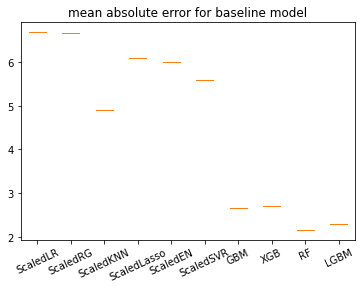

In [38]:
df_to_test_model_3 = X_test_fs_c_fe.copy()
df_to_test_model_3["target"] = y_test_fe
n,r = predict(df_to_train_model_3, df_to_test_model_3)


Model with feature engineering and Mutual Information feature selection

 70%|███████   | 7/10 [04:37<03:00, 60.14s/it]

[16:57:17] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:19] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[16:57:23] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [05:44<00:00, 34.45s/it]


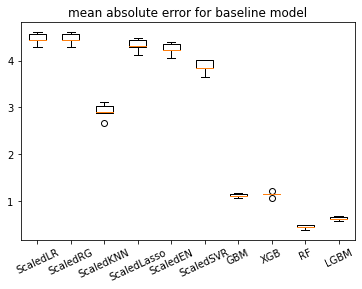

In [21]:
df_to_train_model_4,names_4, results_4 = train(X_train_fs_m_fe, removed_outliers_fe)


 70%|███████   | 7/10 [01:22<00:53, 17.72s/it]

[16:59:51] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


100%|██████████| 10/10 [01:38<00:00,  9.89s/it]


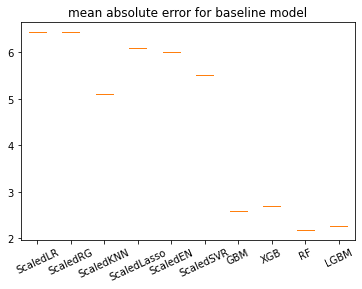

In [22]:
df_to_test_model_4 = X_test_fs_m_fe.copy()
df_to_test_model_4["target"] = y_test_fe
n,r = predict(df_to_train_model_4, df_to_test_model_4)

=>There is no real boost in performance with feature engineering.

# III/Neural models

###A/ With outlier removal

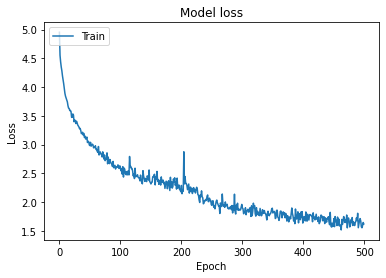

In [23]:
estimator = KerasRegressor(build_fn=larger_model, epochs=500, batch_size=20, verbose=0)
history=estimator.fit(X_train_fs_m, removed_outliers.target)
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Predict

In [26]:
y_preds = history=estimator.predict(X_test_fs_m)


In [33]:
train_error =  np.abs(y_test - y_preds)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)
print("std_error: ",std_error)
print("mean_error: ",mean_error)
print("min_error: ",min_error)
print("max_error: ",max_error)

std_error:  21.0542262224153
mean_error:  3.0362309260157843
min_error:  1.5735626220703125e-05
max_error:  572.3071899414062


In [ ]:
mean_absolute_error(y_preds,y_test)

Visualizing real and predicted Results

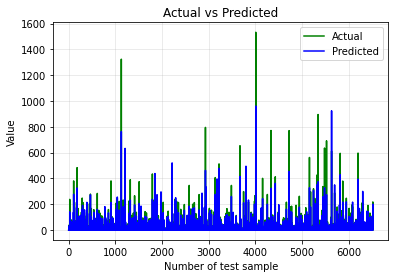

In [36]:

x = np.arange(0,y_test.shape[0])
plt.plot(x,y_test,  color = 'green', label = 'Actual')
plt.plot(x,y_preds, color = 'blue', label = 'Predicted')
plt.grid(alpha = 0.3)
plt.xlabel('Number of test sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()

###B/without outlier removal

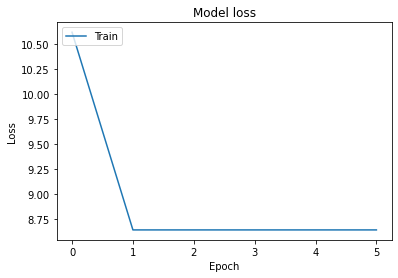

In [65]:
estimator = KerasRegressor(build_fn=larger_model, epochs=6, batch_size=3, verbose=0)
history=estimator.fit(X_train_fs_c_wor, train_target_smooth.target)
plt.plot(history.history['loss'])

plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

=> If we leave the outliers, the customized neural network is too simple and is thus underfitting. 


Predict

In [66]:
y_preds = history=estimator.predict(X_test_fs_c_wor)

In [67]:
train_error =  np.abs(y_test - y_preds)
mean_error = np.mean(train_error)
min_error = np.min(train_error)
max_error = np.max(train_error)
std_error = np.std(train_error)
print("std_error: ",std_error)
print("mean_error: ",mean_error)
print("min_error: ",min_error)
print("max_error: ",max_error)

std_error:  51.55807876027666
mean_error:  12.565581407745892
min_error:  0.0020110607147216797
max_error:  1531.9979889392853


In [68]:
mean_absolute_error(y_preds,y_test)

12.565581407745892

#Visualizing real and predicted Results

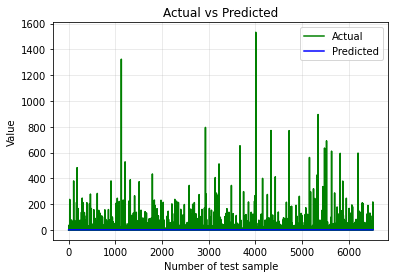

In [69]:
#Visualising the Acutal and predicted Result
x = np.arange(0,y_test.shape[0])
plt.plot(x,y_test,  color = 'green', label = 'Actual')
plt.plot(x,y_preds, color = 'blue', label = 'Predicted')
plt.grid(alpha = 0.3)
plt.xlabel('Number of test sample')
plt.ylabel('Value')
plt.title('Actual vs Predicted')
plt.legend()
plt.show()